In [57]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import pull_data, pull_prediction_data, pull_projections
from train_model import split_data, create_baseline, tune_xgb, create_model
from validate_and_combine import plot_predictions, compile_predictions, combine_projections
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from plotnine import *

START_YEAR = 2021
END_YEAR = 2023
AGG_YEARS = 2
PRED_YEAR = 2024
MODEL_WEIGHT = 0.7
PROJECTION_WEIGHT = 0.3
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.25
PITCHER_SPLIT = 0.35
BATTER_SPLIT_IF = 0.35
BATTER_SPLIT_OF = 0.3

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

# Defining color palette for visualizations
MLB_COLOR_PALETTE = [
    "#0B3D91",  # deep blue
    "#C8102E",  # strong red
    "#FFB81C",  # gold
    "#1F8A70",  # teal/green
    "#6F2DBD",  # bold purple
    "#2F2F2F",  # near-black for accents
]

# Columns for modeling player performance
batting_stat_cols = [
    'IDfg', 'Season', 'Name', 'Age', 'G', 'AB', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'HBP', 'BB', 'IBB', 'SO',
    'GDP', 'GB', 'FB', 'K%', 'SB', 'AVG', 'OBP', 'SLG', 'OPS', 'BABIP', 'RAR', 'WAR', 'wRC+', 'BB/K', 'ISO', 'Spd',
    'wFB', 'wSL', 'wCB', 'wCH', 'WPA', 'Contact%', 'Barrels', 'Barrel%', 'HardHit', 'wOBA', 'SwStr%', 'BsR', 'Soft%',
    'Hard%', 'FB%', 'EV', 'HardHit%', 'XBR', 'xwOBA', 'GB%', 'HR/FB', 'Offense'
]

pitching_stat_cols = [
    'IDfg', 'Season', 'Name', 'Age', 'G', 'GS', 'Pitches', 'Strikes', 'W', 'WAR', 'xERA', 'ERA', 'IP', 'TBF', 'H',
    'ER', 'HR', 'BB', 'SO', 'GB', 'FB', 'AVG', 'WHIP', 'BABIP', 'K/BB', 'K-BB%', 'FIP', 'SwStr%', 'CSW%', 'HR/FB',
    'FBv', 'FB%', 'wFB', 'wSL', 'wCB', 'wCH', 'WPA', 'RAR', 'Swing%', 'K%', 'BB%', 'SIERA', 'Soft%', 'Barrel%',
    'HardHit', 'Hard%', 'Pitching+', 'Location+', 'Stuff+', 'LOB%', 'GB%'
]

# Features that will only be captured via the career data pull
batting_career_cols = [
    "IDfg",
    "G", "AB", "H", "1B", "2B", "3B", "HR", "R", "RBI", "BB", "SO", "SB", 'HBP',
    "AVG", "OBP", "SLG", "OPS", "BABIP", "ISO", "wRC+", "WAR",
]

pitching_career_cols = [
    "IDfg",
    "G", "GS", "IP", "TBF", "W", "SO", "BB", "HR", "ER",
    "ERA", "FIP", "WHIP", "K/BB", "K-BB%", "WAR",
]

In [2]:
batting_df, pitching_df = pull_data(start_year = START_YEAR,
                                    end_year = END_YEAR, 
                                    agg_years=AGG_YEARS, 
                                    save_results=True,
                                    batting_stat_cols=batting_stat_cols, 
                                    pitching_stat_cols=pitching_stat_cols,
                                    batting_career_cols=batting_career_cols,
                                    pitching_career_cols=pitching_career_cols,
                                    career_window_years=10)

# Removing players with fantasy points of 0 to avoid skewing the model, these players are not eligible for drafting anyway
batting_df = batting_df[batting_df['fantasy_points_future'] > 0].reset_index(drop=True)
pitching_df = pitching_df[pitching_df['fantasy_points_future'] > 0].reset_index(drop=True)

Loaded existing data files.


In [3]:
# from pybaseball import batting_stats, pitching_stats

# test = pitching_stats(2021, qual=50)

# display(test)

# Pulling FantasyPros Projection Data

In [4]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [5]:
display(batting_projections.head())

,first_name,last_name,Team,Positions,projected_fantasy_points
0,shohei,ohtani,LAD,"SP,DH",1710
1,aaron,judge,NYY,"LF,CF,RF,DH",1677
2,bobby,witt,KC,SS,1524
3,juan,soto,NYM,"LF,RF",1645
4,ronald,acuna,ATL,RF,1544


In [6]:
# # Reading in training data
# batting_df, pitching_df = load_training_data()

In [7]:
display(batting_df)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,HR,R,RBI,HBP,BB,IBB,SO,GDP,GB,FB,K%,SB,AVG,OBP,SLG,OPS,BABIP,RAR,WAR,wRC+,BB/K,ISO,Spd,wFB,wSL,wCB,wCH,WPA,Contact%,Barrels,Barrel%,HardHit,wOBA,...,Barrels_prior4,Barrel%_prior4,HardHit_prior4,wOBA_prior4,SwStr%_prior4,BsR_prior4,Soft%_prior4,Hard%_prior4,FB%_prior4,EV_prior4,HardHit%_prior4,xwOBA_prior4,GB%_prior4,HR/FB_prior4,fantasy_points_prior4,fantasy_points_future,G_career,AB_career,H_career,1B_career,2B_career,3B_career,HR_career,R_career,RBI_career,BB_career,SO_career,SB_career,HBP_career,AVG_career,OBP_career,SLG_career,OPS_career,BABIP_career,ISO_career,wRC+_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior2,covid_impact_prior4,rookie_year,years_in_league
0,16252,2021,Trea Turner,28,148,595,195,130,34,3,28,107,77,6,41,2,110,18,221,165,0.170,32,0.328,0.375,0.536,0.911,0.362,71.1,7.1,143,0.37,0.208,6.4,21.8,5.3,2.6,2.5,2.39,0.792,36,0.074,226,0.386,...,96.0,0.065,590.0,0.350,0.091,28.0,0.178,0.328,0.333,89.7,0.400,0.341,0.485,0.126,4581.0,1520.0,541.0,2177.0,644.0,422.0,118.0,29.0,75.0,378.0,257.0,182.0,432.0,171.0,15.0,0.296,0.353,0.480,0.833,0.339,0.184,119.0,19.4,5501.0,False,True,True,2015.0,6.0
1,20123,2021,Juan Soto,22,151,502,157,106,20,2,29,111,95,2,145,23,93,23,218,119,0.142,9,0.313,0.465,0.534,0.999,0.332,67.7,6.8,164,1.56,0.221,3.5,41.9,3.5,1.3,2.2,4.01,0.821,55,0.133,218,0.420,...,105.0,0.122,397.0,0.405,0.082,0.2,0.157,0.390,0.329,91.4,0.463,0.404,0.475,0.248,3384.0,1406.0,313.0,1110.0,328.0,182.0,71.0,6.0,69.0,226.0,217.0,228.0,259.0,23.0,4.0,0.295,0.415,0.557,0.972,0.329,0.261,152.0,11.6,3384.0,False,True,True,2018.0,3.0
2,11579,2021,Bryce Harper,28,141,488,151,73,42,1,35,101,84,5,100,14,134,12,143,131,0.224,13,0.309,0.429,0.615,1.044,0.359,66.3,6.7,170,0.75,0.305,4.3,27.6,7.9,-3.1,13.7,4.56,0.695,65,0.181,179,0.431,...,167.0,0.132,573.0,0.384,0.136,-5.0,0.115,0.418,0.387,91.5,0.454,0.398,0.391,0.230,5113.0,980.0,1142.0,4069.0,1122.0,641.0,228.0,21.0,232.0,749.0,668.0,733.0,1055.0,98.0,31.0,0.276,0.387,0.513,0.900,0.315,0.237,138.0,34.3,11297.0,False,True,True,2012.0,9.0
3,13510,2021,Jose Ramirez,28,152,552,147,74,32,5,36,111,103,7,72,10,87,13,167,212,0.137,27,0.266,0.355,0.538,0.893,0.256,64.1,6.4,140,0.83,0.272,7.0,14.4,1.9,4.3,6.8,3.77,0.868,52,0.111,199,0.372,...,112.0,0.069,565.0,0.381,0.053,16.5,0.178,0.362,0.446,88.8,0.350,0.359,0.347,0.150,5247.0,1601.0,828.0,2993.0,840.0,477.0,213.0,23.0,127.0,496.0,437.0,332.0,404.0,127.0,22.0,0.281,0.354,0.494,0.848,0.287,0.214,124.0,27.9,7599.0,False,True,True,2013.0,8.0
4,19611,2021,Vladimir Guerrero Jr.,22,161,604,188,110,29,1,48,123,111,6,86,7,110,20,222,181,0.158,4,0.311,0.401,0.601,1.002,0.313,63.0,6.3,166,0.78,0.290,3.1,40.2,3.1,6.3,0.1,3.22,0.739,75,0.151,274,0.419,...,45.0,0.081,238.0,0.332,0.109,-2.7,0.186,0.358,0.314,90.4,0.427,0.335,0.513,0.137,1447.0,1452.0,183.0,685.0,184.0,117.0,39.0,4.0,24.0,86.0,102.0,66.0,129.0,1.0,4.0,0.269,0.336,0.442,0.778,0.300,0.174,107.0,0.6,1447.0,False,True,True,2019.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,14111,2023,Eric Haase,30,89,274,55,42,8,1,4,22,26,0,17,1,81,11,82,72,0.276,4,0.201,0.247,0.281,0.528,0.268,-11.0,-1.1,42,0.21,0.080,4.1,-15.4,-4.2,-3.3,-2.6,-1.30,0.699,9,0.046,70,0.233,...,54.0,0.112,217.0,0.312,0.160,-0.9,0.166,0.327,0.414,89.1,0.449,0.310,0.391,0.185,1432.0,149.0,234.0,723.0,169.0,101.0,29.0,2.0,37.0,91.0,111.0,52.0,236.0,2.0,4.0,0.234,0.287,0.433,0.720,0.289,0.199,98.0,1.6,1443.0,False,False,True,2018.0,5.0
1253,25845,2023,Michael Toglia,24,45,141,23,14,5,0,4,18,9,1,10,0,50,3,36,39,0.329,1,0.163,0.224,0.284,0.507,0.218,-11.4,-1.1,23,0.20,0.121,3.8,-1.5,-2.6,-2.1,-4.8,-1.45,0.637,5,0.055,40,0.225,...,5.0,0.075,27.0,0.2

In [8]:
display(pitching_df)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,xERA,ERA,IP,TBF,H,ER,HR,BB,SO,GB,FB,AVG,WHIP,BABIP,K/BB,K-BB%,FIP,SwStr%,CSW%,HR/FB,FBv,FB%,wFB,wSL,wCB,wCH,WPA,RAR,Swing%,K%,BB%,SIERA,Soft%,...,FB%_prior4,wFB_prior4,wSL_prior4,wCB_prior4,wCH_prior4,WPA_prior4,RAR_prior4,Swing%_prior4,K%_prior4,BB%_prior4,SIERA_prior4,Soft%_prior4,Barrel%_prior4,HardHit_prior4,Hard%_prior4,Pitching+_prior4,Location+_prior4,Stuff+_prior4,LOB%_prior4,GB%_prior4,fantasy_points_prior4,fantasy_points_future,G_career,GS_career,IP_career,TBF_career,W_career,SO_career,BB_career,HR_career,ER_career,ERA_career,FIP_career,WHIP_career,K/BB_career,K-BB%_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior2,covid_impact_prior4,rookie_year,years_in_league
0,19361,2021,Corbin Burnes,26,28,28,2594,1722,11,7.5,2.00,2.43,167.0,657,123,45,7,34,234,185,115,0.199,0.94,0.309,6.88,0.304,1.63,0.166,0.338,0.061,96.9,0.303,-2.4,7.0,13.3,0.7,3.31,65.3,0.485,0.356,0.052,2.61,0.204,...,0.320,-10.7,7.1,-0.4,0.7,0.92,18.8,0.474,0.308,0.088,3.38,0.177,0.088,133.0,0.365,108.0,97.0,106.0,0.719,0.466,858.6,1197.0,74.0,13.0,146.2,627.0,12.0,193.0,55.0,23.0,73.0,4.48,3.85,1.29,3.51,0.220,2.2,858.6,False,True,True,2018.0,3.0
1,10310,2021,Zack Wheeler,31,32,32,3205,2164,14,7.2,2.78,2.78,213.1,849,169,66,16,46,247,268,148,0.213,1.01,0.288,5.37,0.237,2.59,0.124,0.280,0.108,97.1,0.275,26.0,12.6,2.5,-0.2,3.62,65.3,0.514,0.291,0.054,3.18,0.230,...,0.322,38.7,8.8,1.7,-1.3,2.08,104.8,0.493,0.226,0.072,4.17,0.207,0.055,489.0,0.284,114.0,103.0,111.0,0.732,0.460,2601.0,864.0,137.0,137.0,820.1,3471.0,48.0,779.0,286.0,78.0,337.0,3.70,3.67,1.28,2.72,0.142,14.5,4026.3,False,True,True,2013.0,8.0
2,9132,2021,Nathan Eovaldi,31,32,32,2927,2019,11,5.7,3.36,3.75,182.1,764,182,76,15,35,195,220,182,0.252,1.19,0.326,5.57,0.209,2.79,0.126,0.299,0.082,96.9,0.347,0.1,0.3,6.9,0.0,1.86,53.1,0.515,0.255,0.046,3.60,0.167,...,0.344,2.2,4.2,-0.5,0.0,0.69,26.4,0.504,0.233,0.065,3.99,0.171,0.073,250.0,0.356,120.0,110.0,113.0,0.725,0.460,1074.0,525.3,188.0,169.0,966.0,4131.0,50.0,762.0,301.0,104.0,458.0,4.27,3.97,1.36,2.53,0.112,12.9,4060.0,False,True,True,2011.0,10.0
3,19374,2021,Walker Buehler,26,33,33,3152,2120,16,5.6,3.08,2.47,207.2,815,149,57,19,52,212,238,189,0.197,0.97,0.247,4.08,0.196,3.16,0.116,0.296,0.101,95.4,0.355,22.9,5.9,2.3,4.6,3.84,52.0,0.488,0.260,0.064,3.73,0.174,...,0.339,46.6,9.1,-0.1,-4.6,4.56,81.5,0.489,0.286,0.063,3.49,0.177,0.052,324.0,0.374,128.0,94.0,137.0,0.734,0.453,2091.6,312.0,70.0,61.0,365.2,1469.0,24.0,420.0,93.0,41.0,128.0,3.15,3.23,1.03,4.52,0.223,8.7,2091.6,False,True,True,2017.0,4.0
4,3137,2021,Max Scherzer,36,30,30,2821,1871,15,5.4,2.88,2.46,179.1,693,119,49,23,36,236,136,196,0.184,0.86,0.247,6.56,0.289,2.97,0.159,0.316,0.117,94.3,0.483,19.9,13.2,-0.2,5.8,4.37,49.2,0.503,0.341,0.052,2.90,0.170,...,0.438,57.7,70.2,-5.1,8.6,12.71,200.9,0.516,0.343,0.062,2.93,0.207,0.065,500.0,0.304,115.0,105.0,112.0,0.802,0.365,4336.0,898.3,300.0,300.0,1935.1,7795.0,154.0,2360.0,487.0,219.0,668.0,3.11,3.01,1.06,4.85,0.240,52.7,11651.3,False,True,True,2008.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,14552,2023,Jose Ruiz,28,38,1,821,492,2,-0.7,5.59,5.89,44.1,207,52,29,10,21,39,55,51,0.289,1.65,0.321,1.86,0.087,6.26,0.122,0.263,0.196,96.4,0.362,-2.9,0.0,-6.0,-1.0,-0.47,-7.4,0.455,0.188,0.101,4.71,0.156,...,0.399,-7.8,-4.0,5.3,-1.0,-3.60,4.8,0.475,0.229,0.110,4.28,0.163,0.081,215.0,0.323,101.0,100.0,99.0,0.753,0.405,798.6,271.0,174.0,1.0,175.0,773.0,3.0,178.0,86.0,25.0,81.0,4.17,4.49,1.45,2.07,0.119,0.5,831.0,False,False,True,2017.0,6.0
1231,20167,2023,Kyle Muller,25,21,13,1457,900,1,-0.7,7.38,7.60,77.0,372,112,65,16,39,56,115,96,0.339,1.96,0.372,1.44,0.046,6.14,0.091,0.

# Defining Baseline Model

## Creating baseline batting predictions

In [ ]:
## TODO: Fix up the docstrings and comments throughout the core python modules
## TODO: Incorporate visualizations from NBA modeling process
## TODO: Adjust final projection values with methodology from NFL modeling process to use updated relative player value calculations

In [39]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

Validation Root Mean Squared Error: 302.08054783322046
Validation Mean Absolute Error: 244.8110873509967
Validation R^2 Score: 0.520839143718624
Test Root Mean Squared Error: 326.74176014836286
Test Mean Absolute Error: 270.247070070297
Test R^2 Score: 0.4555278848671367


In [13]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

,Name,fantasy_points_future,fantasy_points_pred,diff,Season,Age,fantasy_points
75,Jose Ramirez,1601.0,1574.956543,26.043457,2021,28,1587
116,Austin Riley,912.0,1438.928223,526.928223,2023,26,1551
221,Fernando Tatis Jr.,932.0,1405.627075,473.627075,2023,24,1345
166,Ronald Acuna Jr.,461.0,1401.251221,940.251221,2023,25,2132
125,Paul Goldschmidt,1624.0,1390.131226,233.868774,2021,33,1529
...,...,...,...,...,...,...,...
85,Luke Maile,189.0,221.222855,32.222855,2023,32,347
70,Jonathan Davis,150.0,191.247955,41.247955,2021,29,152
54,Jason Delay,298.0,189.743286,108.256714,2022,27,213
86,Tucker Barnhart,132.0,182.933121,50.933121,2023,32,155


In [16]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

,Name,fantasy_points_future,fantasy_points_pred,diff,Season,Age,fantasy_points
147,Jesus Luzardo,276.6,1024.675171,748.075171,2023,25,995.6
122,Aaron Nola,1153.0,991.941406,161.058594,2021,28,975.6
216,Luis Castillo,892.3,986.224487,93.924487,2023,30,1099.0
197,Pablo Lopez,972.3,982.144226,9.844226,2023,27,1102.0
102,Jose Berrios,723.0,966.001404,243.001404,2021,27,1023.0
...,...,...,...,...,...,...,...
19,Yonny Chirinos,102.0,165.438049,63.438049,2023,29,286.0
203,Luis Frias,134.0,163.167831,29.167831,2022,24,38.0
46,Noe Ramirez,241.0,139.144180,101.855820,2021,31,159.0
146,J.P. Feyereisen,167.3,119.982651,47.317349,2021,28,296.0


# Building Final Models

In [ ]:
MAX_DEPTH_CHOICES = [3, 4, 5, 6, 7]

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.02), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.7, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(15.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(12.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-4), np.log(4.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(4.0)),
}

# Batting Predictions

In [118]:
def theme_mlb():
    """
    Custom plotnine theme for MLB:
    - clean/classic feel
    - slightly bolder titles
    - faint gridlines for readability
    """
    return theme_classic() + theme(
        text=element_text(family="serif"),
        plot_title=element_text(size=20, weight="bold"),
        axis_title=element_text(size=16),
        axis_text=element_text(size=14),
        legend_title=element_text(size=12),
        legend_text=element_text(size=11),
        panel_border=element_blank(),
        panel_background=element_rect(fill="white", color=None),
        panel_grid_major=element_line(color="#e6e6e6", size=0.35),
        panel_grid_minor=element_line(color="#f2f2f2", size=0.25),
        figure_size=(10, 6),
    )

def _ensure_prediction_diff(
    df: pd.DataFrame,
    *,
    actual_col: str,
    pred_col: str,
    diff_col: str,
) -> pd.DataFrame:
    """
    Ensure a signed residual column exists in the results dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        Results dataframe.
    actual_col : str
        Column containing actual values.
    pred_col : str
        Column containing predicted values.
    diff_col : str
        Desired column name for signed residuals, defined as (pred - actual).

    Returns
    -------
    pd.DataFrame
        Copy of df with diff_col present.
    """
    out = df.copy()
    if diff_col not in out.columns:
        out[diff_col] = out[pred_col] - out[actual_col]
    return out


def _build_outlier_labels(
    df: pd.DataFrame,
    *,
    name_col: str,
    season_col: str,
    add_one_to_season: bool = False,
) -> pd.Series:
    """
    Construct formatted outlier labels of the form: '<Name> (<Season>)'.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing name and season columns.
    name_col : str
        Player name column.
    season_col : str
        S    Returns
    -------
    pd.Series
        String labels aligned with df rows.
    """
    season = df[season_col]
    if add_one_to_season:
        season = season + 1
    return df[name_col].astype(str) + " (" + season.astype(int).astype(str) + ")"

def plot_actual_vs_pred_mlb(
    results: pd.DataFrame,
    color_palette: list[str] = MLB_COLOR_PALETTE,
    *,
    actual_col: str = "fantasy_points_future",
    pred_col: str = "predicted_fantasy_points",
    diff_col: str = "prediction_diff",
    name_col: str = "Name",
    season_col: str = "Season",
    top_n: int = 15,
    x_offset: float = 15,
    y_offset: float = 40,
    add_one_to_season_in_label: bool = False,
):
    """
    Plot actual vs. predicted fantasy points with:
      - blue scatter points
      - fitted linear trend line with a blue-tinted confidence band
      - a subtle 45° reference line (perfect predictions)
      - labeled top-N outliers by absolute residual

    Parameters
    ----------
    results : pd.DataFrame
        DataFrame containing prediction results. Must include:
        - `actual_col` (actual values)
        - `pred_col` (predicted values)
        - `name_col` (player display name)
        - `season_col` (season identifier)
        Optionally includes `diff_col` (signed residuals). If absent, it will be
        computed as (predicted - actual).
    color_palette : list[str], default MLB_COLOR_PALETTE
        List of hex color codes used for plot styling.
    actual_col : str, default "fantasy_points_future"
        Column name containing actual target values.
    pred_col : str, default "predicted_fantasy_points"
        Column name containing model predictions.
    diff_col : str, default "prediction_diff"
        Column name for signed residuals (predicted - actual).
    name_col : str, default "Name"
        Column name containing player names.
    season_col : str, default "Season"
        Column name containing the season/year.
    top_n : int, default 15
        Number of highest absolute-error points to label.
    x_offset : float, default 15
        Horizontal label offset applied to outlier labels.
    y_offset : float, default 40
        Vertical label offset applied to outlier labels.
    add_one_to_season_in_label : bool, default False
        If True, labels display (Season + 1). Helpful when the plotted target is
        the following season and you want labels to reflect that year.

    Returns
    -------
    plotnine.ggplot
        A plotnine ggplot object.
    """
    df = _ensure_prediction_diff(
        results,
        actual_col=actual_col,
        pred_col=pred_col,
        diff_col=diff_col,
    )

    top_outliers = (
        df.reindex(df[diff_col].abs().sort_values(ascending=False).index)
        .head(top_n)
        .copy()
    )

    top_outliers["label"] = _build_outlier_labels(
        top_outliers,
        name_col=name_col,
        season_col=season_col,
        add_one_to_season=add_one_to_season_in_label,
    )
    top_outliers["label_x"] = top_outliers[pred_col] + x_offset
    top_outliers["label_y"] = top_outliers[actual_col] + y_offset

    p = (
        ggplot(df, aes(x=pred_col, y=actual_col))

        # Scatter points (primary visual)
        + geom_point(alpha=0.8, size=2, color=color_palette[0])

        # Fitted line + confidence interval (same hue, very light ribbon)
        + geom_smooth(
            method="lm",
            se=True,
            level=0.99,
            color="#4A79B8",
            fill="#AFC7E8",
            alpha=0.18,
            size=0.4,
        )

        # Perfect-prediction reference line (subtle so it doesn't compete)
        + geom_abline(
            slope=1,
            intercept=0,
            linetype="dashed",
            color="grey",
            alpha=0.30,
        )

        # Outlier callouts
        + geom_segment(
            top_outliers,
            aes(x=pred_col, y=actual_col, xend="label_x", yend="label_y"),
            color="darkgrey",
            size=0.3,
            alpha=0.85,
        )
        + geom_text(
            top_outliers,
            aes(x="label_x", y="label_y", label="label"),
            size=7,
            ha="left",
            va="bottom",
            fontstyle="italic",
        )

        # Labels + scales + theme
        + labs(
            title="Actual vs Predicted Fantasy Points",
            x="Predicted Fantasy Points",
            y="Actual Fantasy Points (Future Season)",
        )
        + scale_x_continuous(expand=(0.12, 0))
        + scale_y_continuous(limits=(0, None))
        + theme_mlb()
        + theme(figure_size=(12, 10))
    )

    return p

def plot_resid_vs_pred_mlb(
    results: pd.DataFrame,
    color_palette: list[str] = MLB_COLOR_PALETTE,
    *,
    actual_col: str = "fantasy_points_future",
    pred_col: str = "predicted_fantasy_points",
    diff_col: str = "prediction_diff",
    name_col: str = "Name",
    season_col: str = "Season",
    top_n: int = 25,
    x_offset: float = 25,
    y_offset: float = 25,
    band: float = 300,
    add_one_to_season_in_label: bool = False,
    reverse_y: bool = True,
):
    """
    Plot residuals vs predicted values, labeling the largest outliers.

    Residual definition:
        prediction_diff = predicted - actual

    This diagnostic is useful for:
    - checking heteroskedasticity (error magnitude changes by predicted score)
    - identifying systematic bias (residuals drifting above/below zero)
    - quickly spotting extreme misses and their location in prediction space

    Parameters
    ----------
    results : pd.DataFrame
        DataFrame containing prediction results. Must include:
        - `actual_col` (actual values)
        - `pred_col` (predicted values)
        - `name_col` (player display name)
        - `season_col` (season identifier)
        Optionally includes `diff_col`. If absent, it will be computed.
    color_palette : list[str], default MLB_COLOR_PALETTE
        List of hex color codes used for plot styling.
    actual_col : str, default "fantasy_points_future"
        Column name containing actual target values.
    pred_col : str, default "predicted_fantasy_points"
        Column name containing model predictions.
    diff_col : str, default "prediction_diff"
        Column name for signed residuals (predicted - actual).
    name_col : str, default "Name"
        Column name containing player names.
    season_col : str, default "Season"
        Column name containing the season/year.
    top_n : int, default 25
        Number of highest absolute residuals to label.
    x_offset : float, default 25
        Horizontal label offset applied to outlier labels.
    y_offset : float, default 25
        Vertical label offset applied to outlier labels. Sign is automatically
        adjusted to nudge labels away from the point (based on residual sign).
    band : float, default 300
        Symmetric residual band (+/- band) shaded in the background to provide a
        quick view of "typical" prediction errors.
    add_one_to_season_in_label : bool, default False
        If True, labels display (Season + 1). Helpful when the target is the
        following season and you want labels to reflect that year.
    reverse_y : bool, default True
        If True, reverses the y-axis (mirrors the NBA plot convention you used).
        If you prefer standard residual orientation, set to False.

    Returns
    -------
    plotnine.ggplot
        A plotnine ggplot object.
    """
    df = _ensure_prediction_diff(
        results,
        actual_col=actual_col,
        pred_col=pred_col,
        diff_col=diff_col,
    )

    top_outliers = (
        df.reindex(df[diff_col].abs().sort_values(ascending=False).index)
        .head(top_n)
        .copy()
    )

    top_outliers["label"] = _build_outlier_labels(
        top_outliers,
        name_col=name_col,
        season_col=season_col,
        add_one_to_season=add_one_to_season_in_label,
    )
    top_outliers["label_x"] = top_outliers[pred_col] + x_offset
    top_outliers["label_y"] = top_outliers[diff_col] + (
        y_offset * np.sign(top_outliers[diff_col])
    )

    p = (
        ggplot(df, aes(x=pred_col, y=diff_col))
        + labs(
            title="Residuals vs Predicted Fantasy Points",
            x="Predicted Fantasy Points",
            y="Prediction Diff (Predicted - Actual)",
        )
        + geom_point(alpha=0.8, size=1.5, color=color_palette[1])
        + geom_hline(yintercept=0, linetype="dashed", color="grey", alpha=0.7)
        + annotate(
            "rect",
            xmin=-np.inf,
            xmax=np.inf,
            ymin=-band,
            ymax=band,
            alpha=0.18,
            fill="lightgrey",
        )
        + geom_segment(
            top_outliers,
            aes(x=pred_col, y=diff_col, xend="label_x", yend="label_y"),
            color="darkgrey",
            size=0.3,
            alpha=0.85,
        )
        + geom_text(
            top_outliers,
            aes(x="label_x", y="label_y", label="label"),
            size=7,
            ha="left",
            va="bottom",
            fontstyle="italic",
        )
        + theme_mlb()
        + theme(figure_size=(12, 10))
    )

    if reverse_y:
        p = p + scale_y_reverse()

    return p

def plot_resid_hist_mlb(
    results: pd.DataFrame,
    color_palette: list[str] = MLB_COLOR_PALETTE,
    *,
    actual_col: str = "fantasy_points_future",
    pred_col: str = "predicted_fantasy_points",
    diff_col: str = "prediction_diff",
    band: float = 300,
    binwidth: float = 50,
    x_annotate: float | None = None,
    y_annotate: float | None = None,
):
    """
    Plot a histogram of residuals with an annotated +/- error band.

    Residual definition:
        prediction_diff = predicted - actual

    This diagnostic is useful for:
    - understanding the shape and spread of model errors
    - estimating the share of predictions within a practical error tolerance band
    - spotting skew (consistent over/under-prediction)

    Parameters
    ----------
    results : pd.DataFrame
        DataFrame containing prediction results. Must include `diff_col`, or must
        include both `pred_col` and `actual_col` so residuals can be computed.
    color_palette : list[str], default MLB_COLOR_PALETTE
        List of hex color codes used for plot styling.
    actual_col : str, default "fantasy_points_future"
        Column name containing actual target values.
    pred_col : str, default "predicted_fantasy_points"
        Column name containing model predictions.
    diff_col : str, default "prediction_diff"
        Column name for signed residuals (predicted - actual).
    band : float, default 300
        Symmetric residual band (+/- band) shaded in the background.
    binwidth : float, default 50
        Histogram bin width for residual distribution.
    x_annotate : float | None, default None
        X-position for the annotation text. If None, uses an 85th-percentile
        heuristic based on the residual distribution.
    y_annotate : float | None, default None
        Y-position for the annotation text. If None, defaults to 0. You may want
        to set this explicitly if the label overlaps with bins in your dataset.

    Returns
    -------
    plotnine.ggplot
        A plotnine ggplot object.
    """
    df = _ensure_prediction_diff(
        results,
        actual_col=actual_col,
        pred_col=pred_col,
        diff_col=diff_col,
    )

    within_pct = int((df[diff_col].abs() <= band).mean() * 100)

    # Heuristics for annotation placement if not provided
    if x_annotate is None:
        x_annotate = float(df[diff_col].quantile(0.85))
    if y_annotate is None:
        y_annotate = 0

    p = (
        ggplot(df, aes(x=diff_col))
        + geom_histogram(
            binwidth=binwidth,
            fill=color_palette[2],
            alpha=0.95,
            color="white",
        )
        + annotate(
            "rect",
            xmin=-band,
            xmax=band,
            ymin=-float("inf"),
            ymax=float("inf"),
            alpha=0.18,
            fill="lightgrey",
        )
        + annotate(
            "text",
            x=x_annotate,
            y=y_annotate,
            label=f"{within_pct}% of predictions within +/- {int(band)}",
            size=14,
            ha="left",
            va="top",
            color="black",
            alpha=0.75,
            fontweight="bold",
        )
        + labs(
            title="Distribution of Prediction Errors",
            x="Prediction Diff (Predicted - Actual)"
        )
        + theme_mlb()
        + theme(axis_title_y=element_blank())
    )

    return p

In [62]:
def compile_predictions(
    complete_df: pd.DataFrame,
    test_df: pd.DataFrame,
    y_test: pd.Series,
    y_pred,
    *,
    id_col: str = "IDfg",
    name_col: str = "Name",
    season_col: str = "Season",
    actual_col: str = "fantasy_points_future",
) -> pd.DataFrame:
    """
    Compile a results dataframe that aligns with the NBA plotting conventions.

    Output columns (core):
      - Name
      - Season
      - predicted_fantasy_points
      - fantasy_points_future
      - prediction_diff (predicted - actual)
      - absolute_diff (abs(predicted - actual))

    This output plugs directly into:
      - plot_actual_vs_pred_mlb(..., pred_col="predicted_fantasy_points")
      - plot_resid_vs_pred_mlb(..., pred_col="predicted_fantasy_points")
      - plot_resid_hist_mlb(...)
    """

    # Copy so we don't mutate caller dataframes
    test_df_out = test_df.copy()

    # Attach predictions + actuals (aligned naming)
    test_df_out["predicted_fantasy_points"] = y_pred
    test_df_out[actual_col] = y_test

    # Pull minimal metadata from the full dataset for Name/Season join
    meta_df = complete_df[[id_col, name_col, season_col]].drop_duplicates(
        subset=[id_col, season_col]
    )

    # Merge metadata onto test rows
    results = test_df_out.merge(meta_df, on=[id_col, season_col], how="left")

    # Compute diffs
    results["prediction_diff"] = (
        results["predicted_fantasy_points"] - results[actual_col]
    )
    results["absolute_diff"] = results["prediction_diff"].abs()

    # Select output columns (only keep what exists)
    desired_cols = [
        name_col,
        actual_col,
        "predicted_fantasy_points",
        "prediction_diff",
        "absolute_diff",
        season_col,
        "Age",
        "fantasy_points",
    ]
    desired_cols = [c for c in desired_cols if c in results.columns]

    results = results[desired_cols].sort_values(
        by="predicted_fantasy_points", ascending=False
    )

    return results

In [ ]:
## TODO: Add Under and Over performer annotations to residual plots
## TODO: Add decile calibration plot to process

In [67]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=50,
    random_state=62820,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 50/50 [00:24<00:00,  2.08trial/s, best loss: 279.78697199039135]
Best Parameters: {'learning_rate': 0.19474682873003937, 'max_depth': 3, 'subsample': 0.8135855402379303, 'colsample_bytree': 0.8906221544968064, 'min_child_weight': 8.56199635212813, 'reg_lambda': 11.34617474947735, 'reg_alpha': 0.035509188532531044, 'gamma': 0.20841167514765876}
[Best trial @ val] optimized=rmse | RMSE=279.787 | MAE=226.571 | ASYM=99120.772


In [68]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=62820,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 31
[Val] RMSE: 279.787 | MAE: 226.571 | R^2: 0.589 | ASYM: 99120.772
[Test] RMSE: 310.448 | MAE: 254.384 | R^2: 0.508 | ASYM: 122303.034


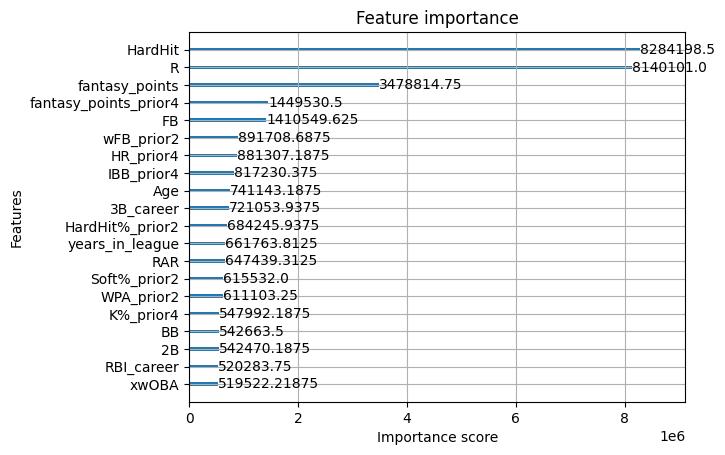

In [43]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=20)
plt.show()

In [69]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
75,Jose Ramirez,1601.0,1538.418701,-62.581299,62.581299,2021,28,1587
166,Ronald Acuna Jr.,461.0,1436.367798,975.367798,975.367798,2023,25,2132
82,Shohei Ohtani,2143.0,1432.041016,-710.958984,710.958984,2023,28,1635
187,Mookie Betts,1170.0,1408.901733,238.901733,238.901733,2023,30,1769
127,Freddie Freeman,1648.0,1383.777100,-264.222900,264.222900,2021,31,1559
...,...,...,...,...,...,...,...,...
70,Jonathan Davis,150.0,264.551514,114.551514,114.551514,2021,29,152
86,Tucker Barnhart,132.0,257.702087,125.702087,125.702087,2023,32,155
101,Jon Singleton,701.0,256.423523,-444.576477,444.576477,2023,31,153
234,Yonathan Daza,693.0,230.487915,-462.512085,462.512085,2021,27,504


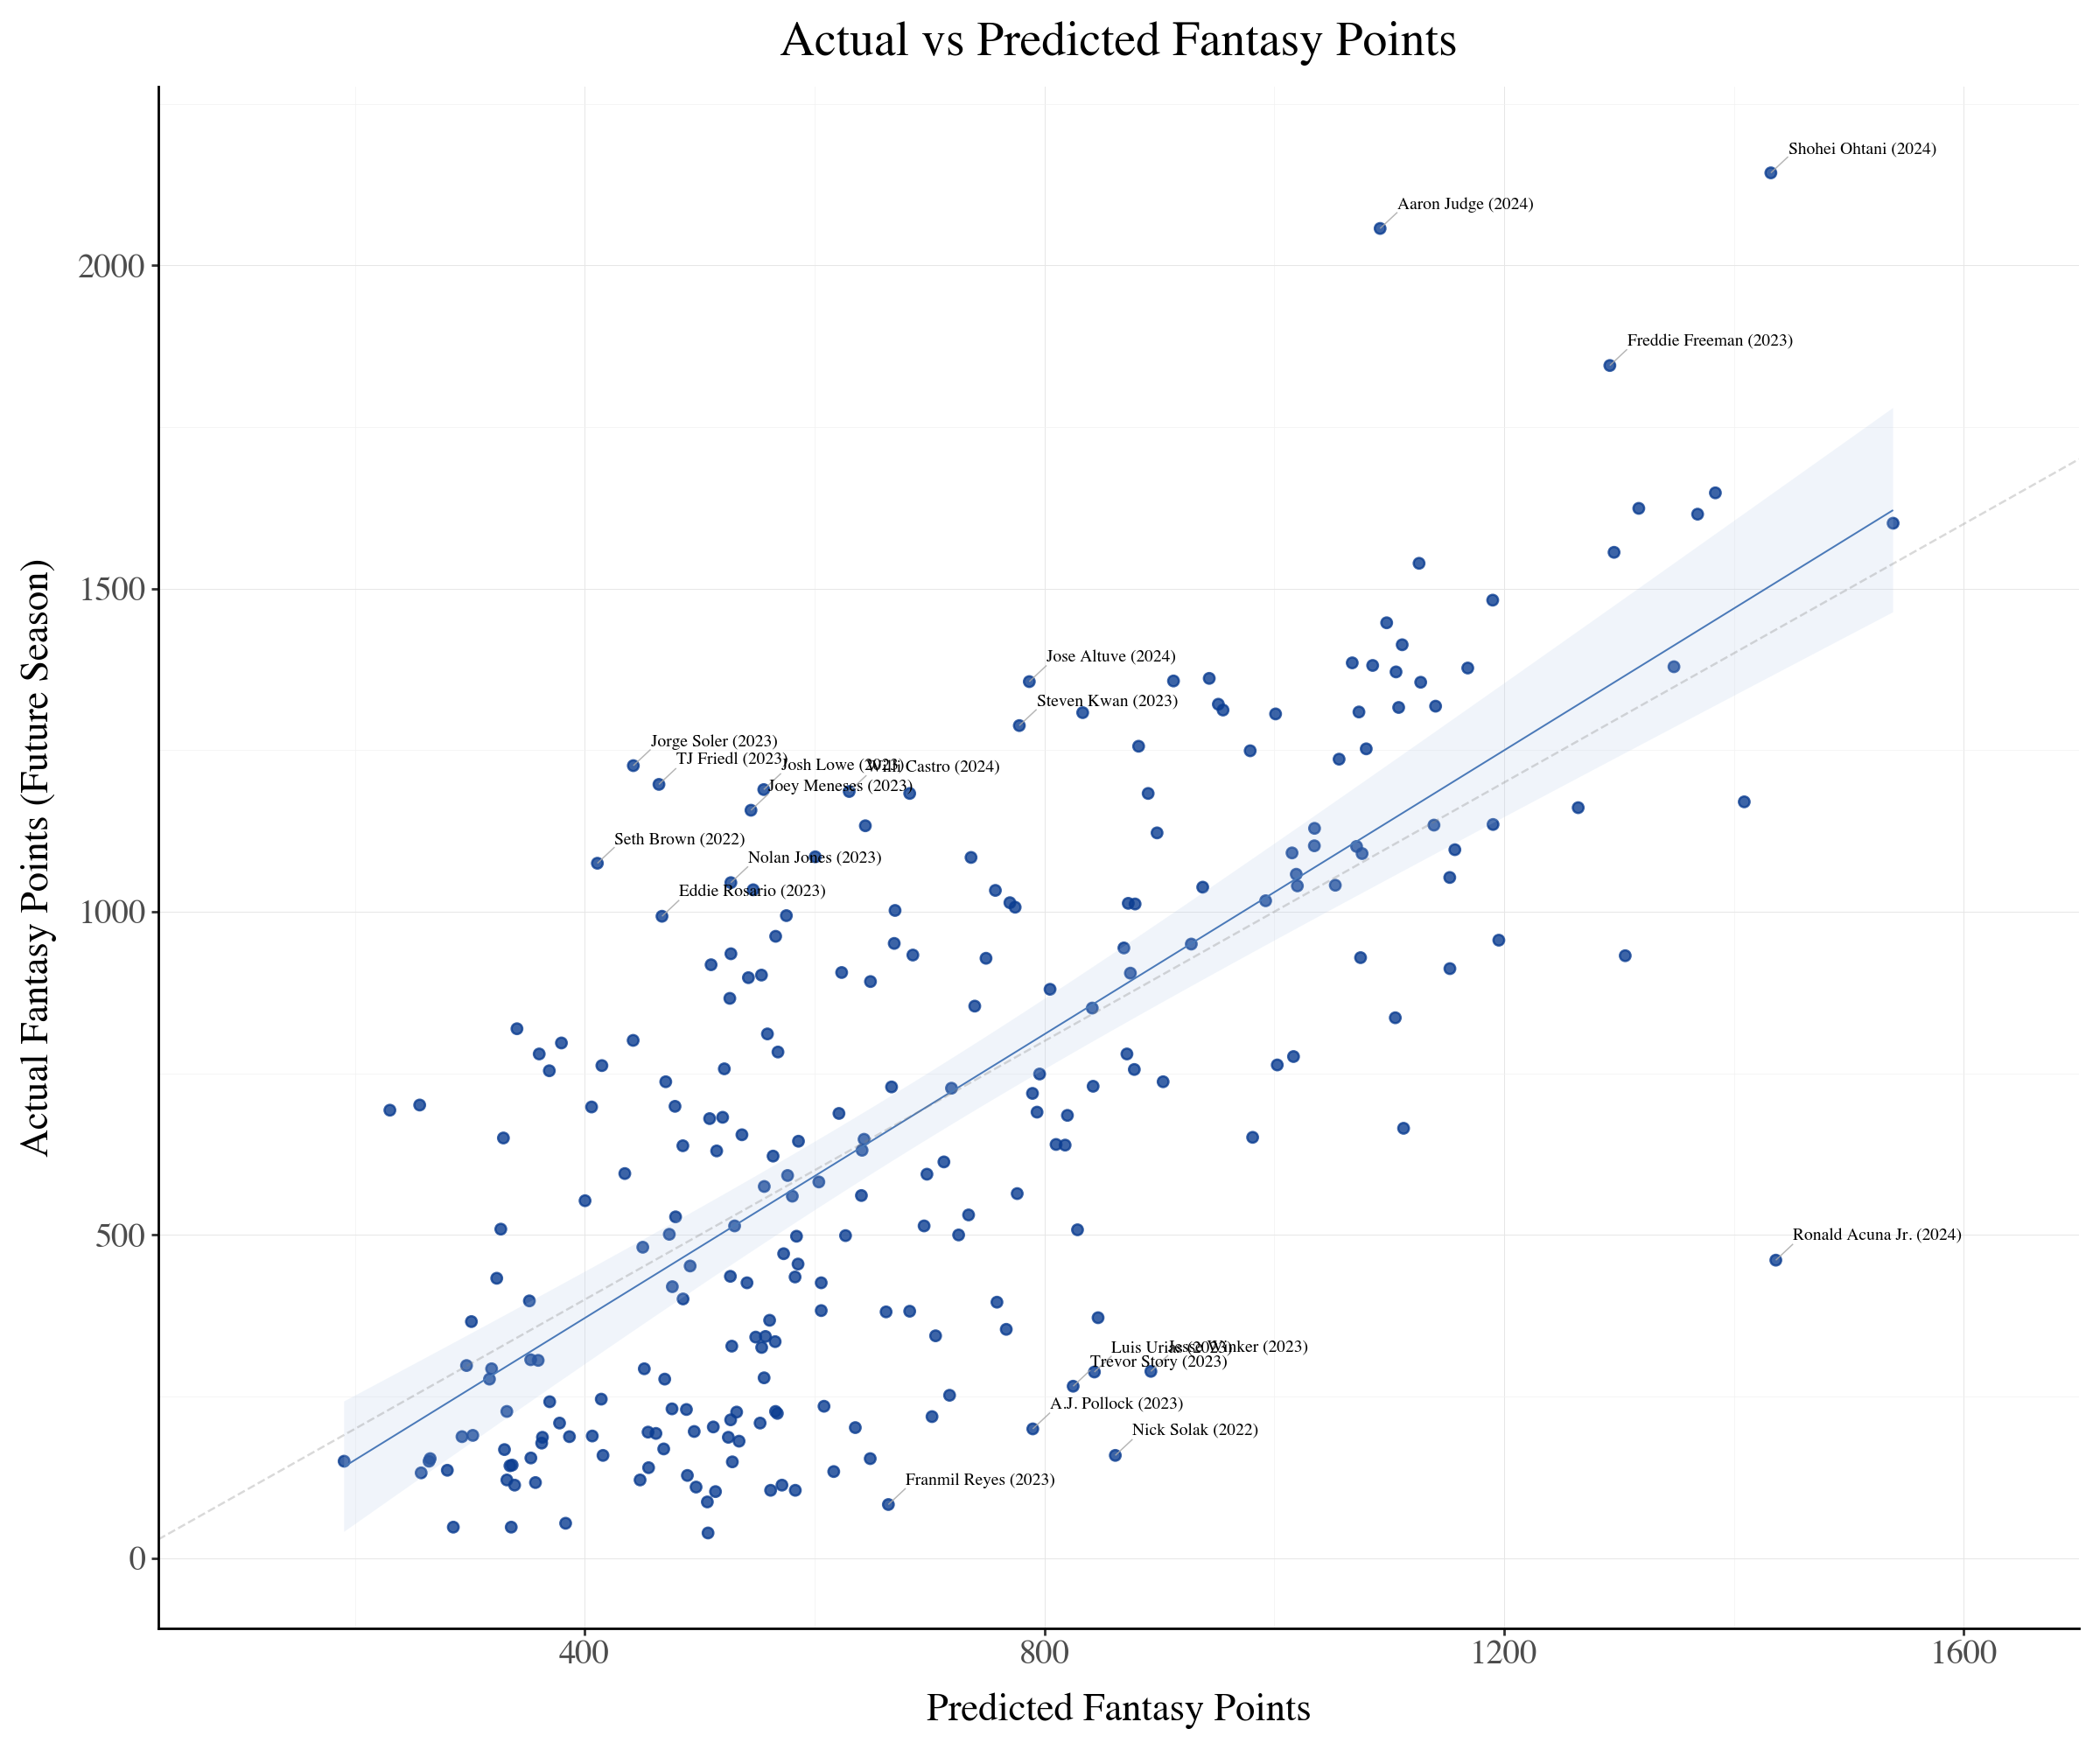

In [127]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=20,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

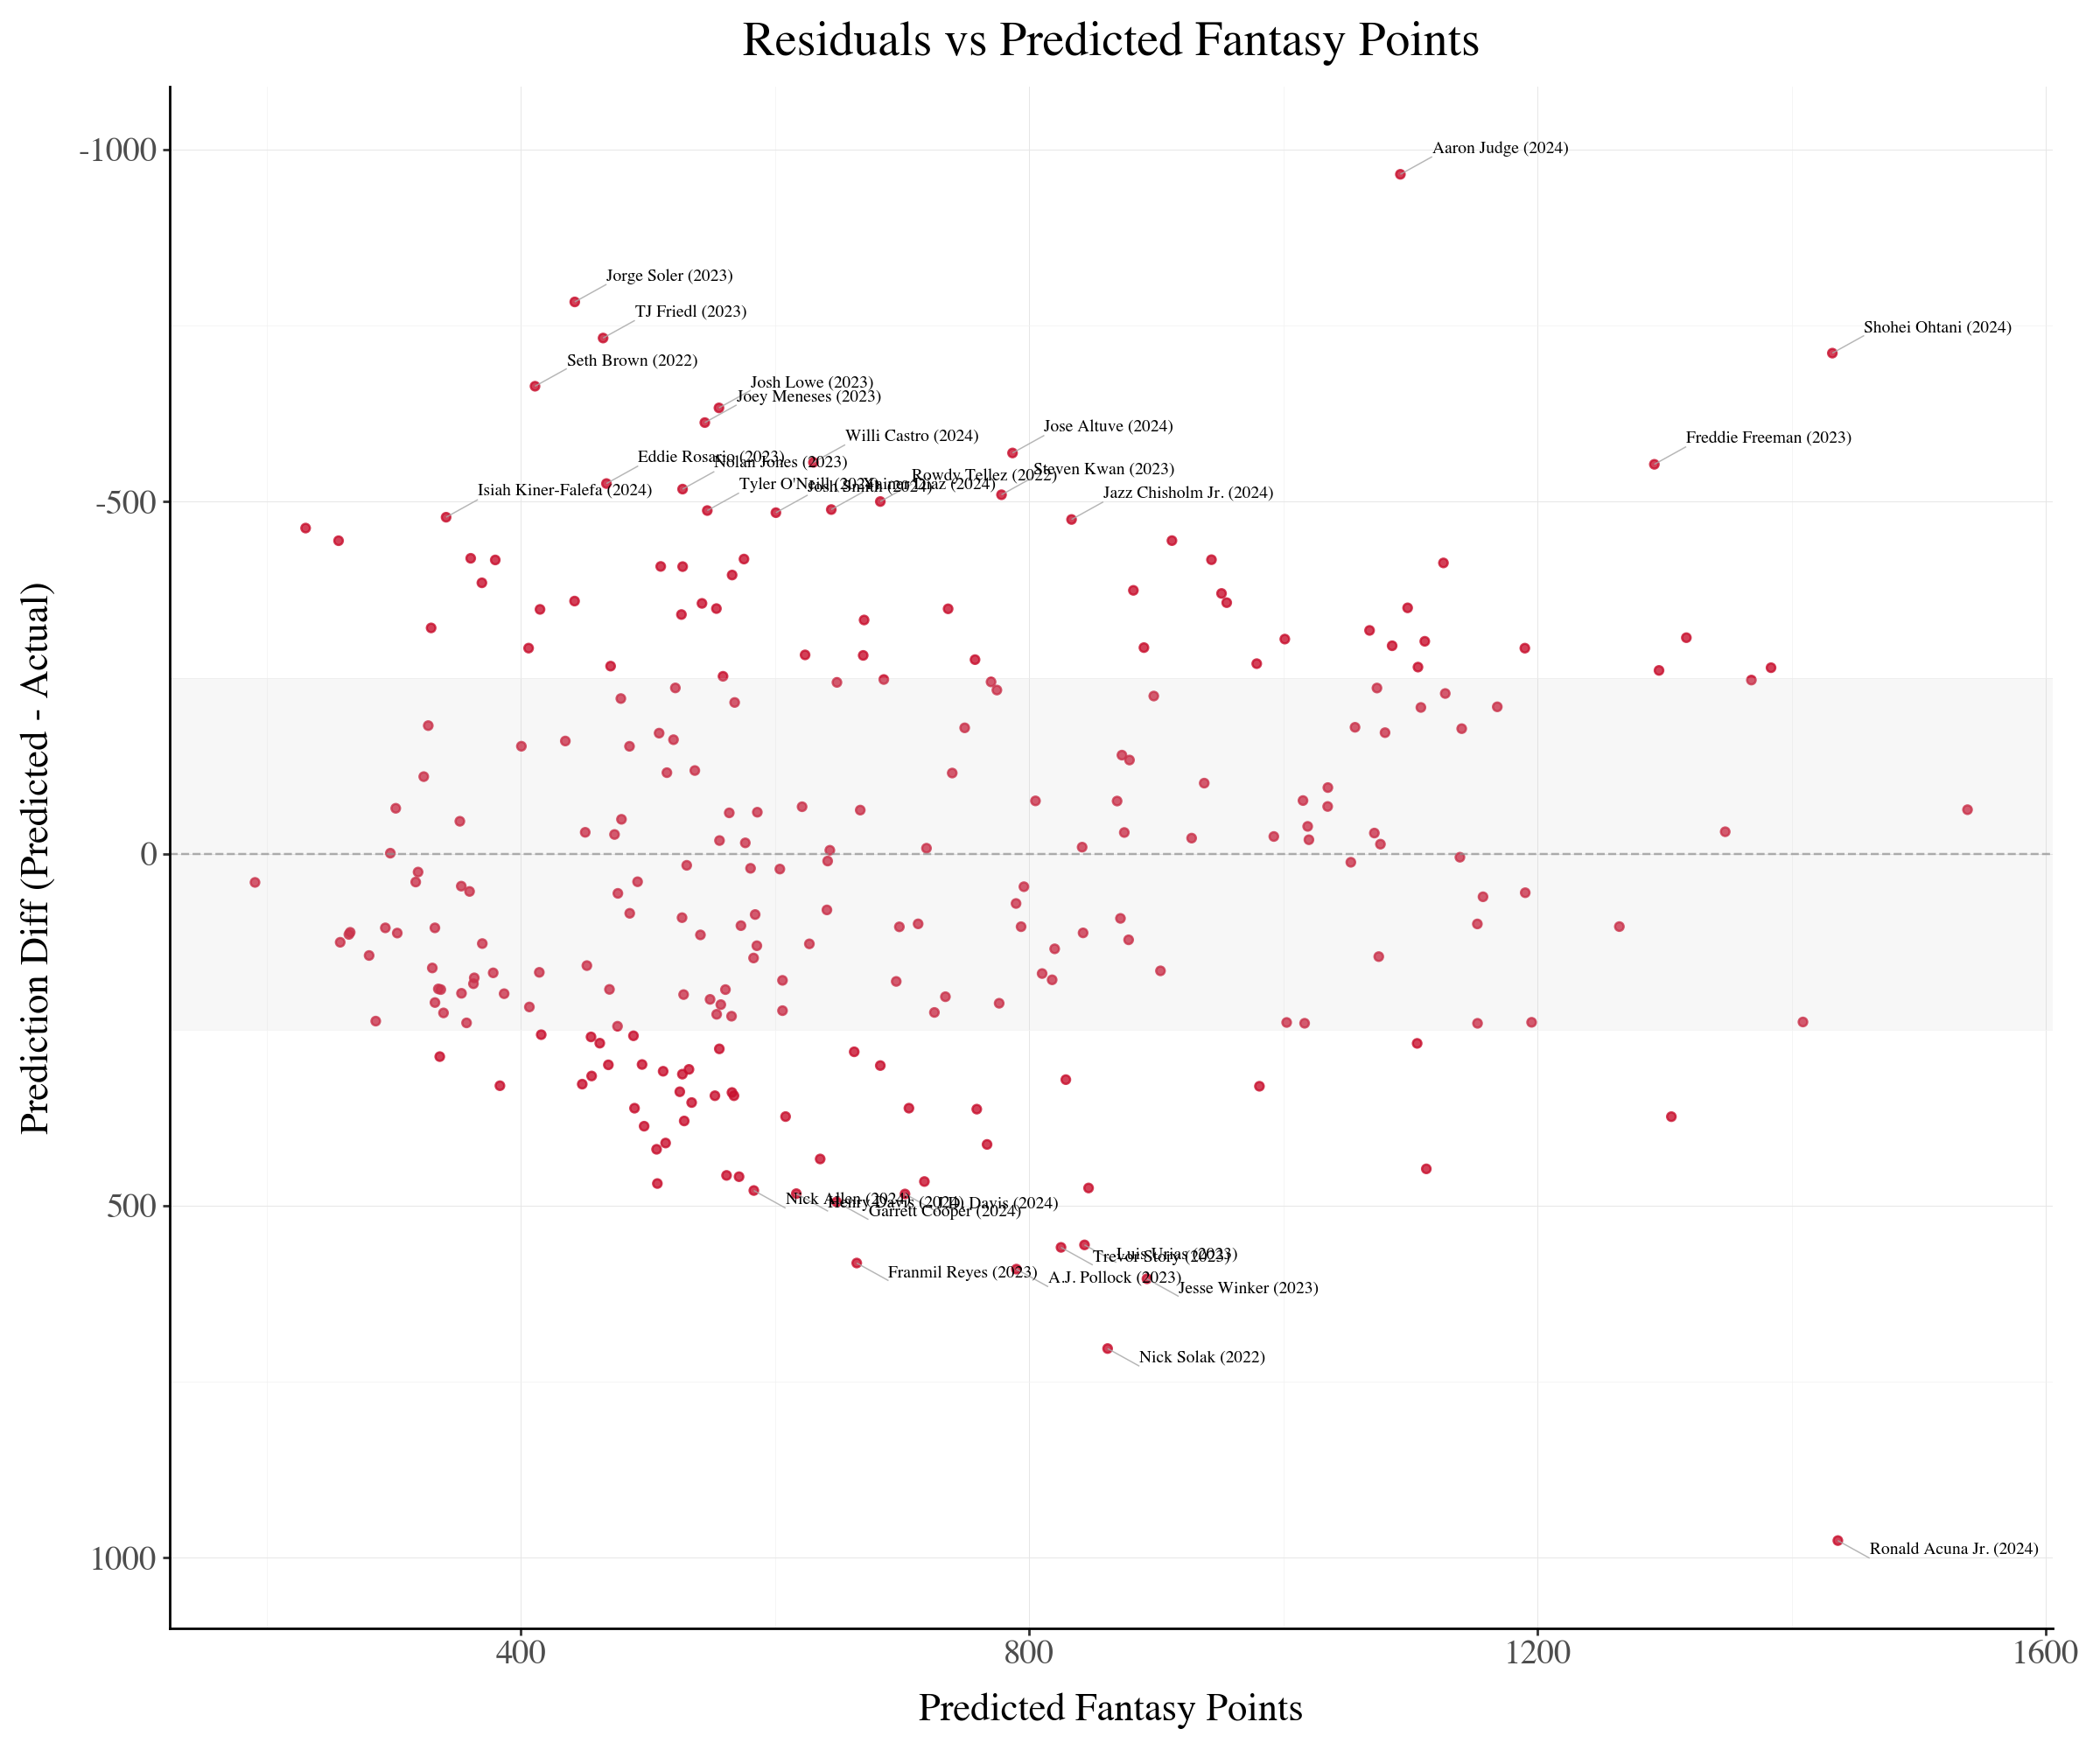

In [128]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,          # tighter "acceptable error" band
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

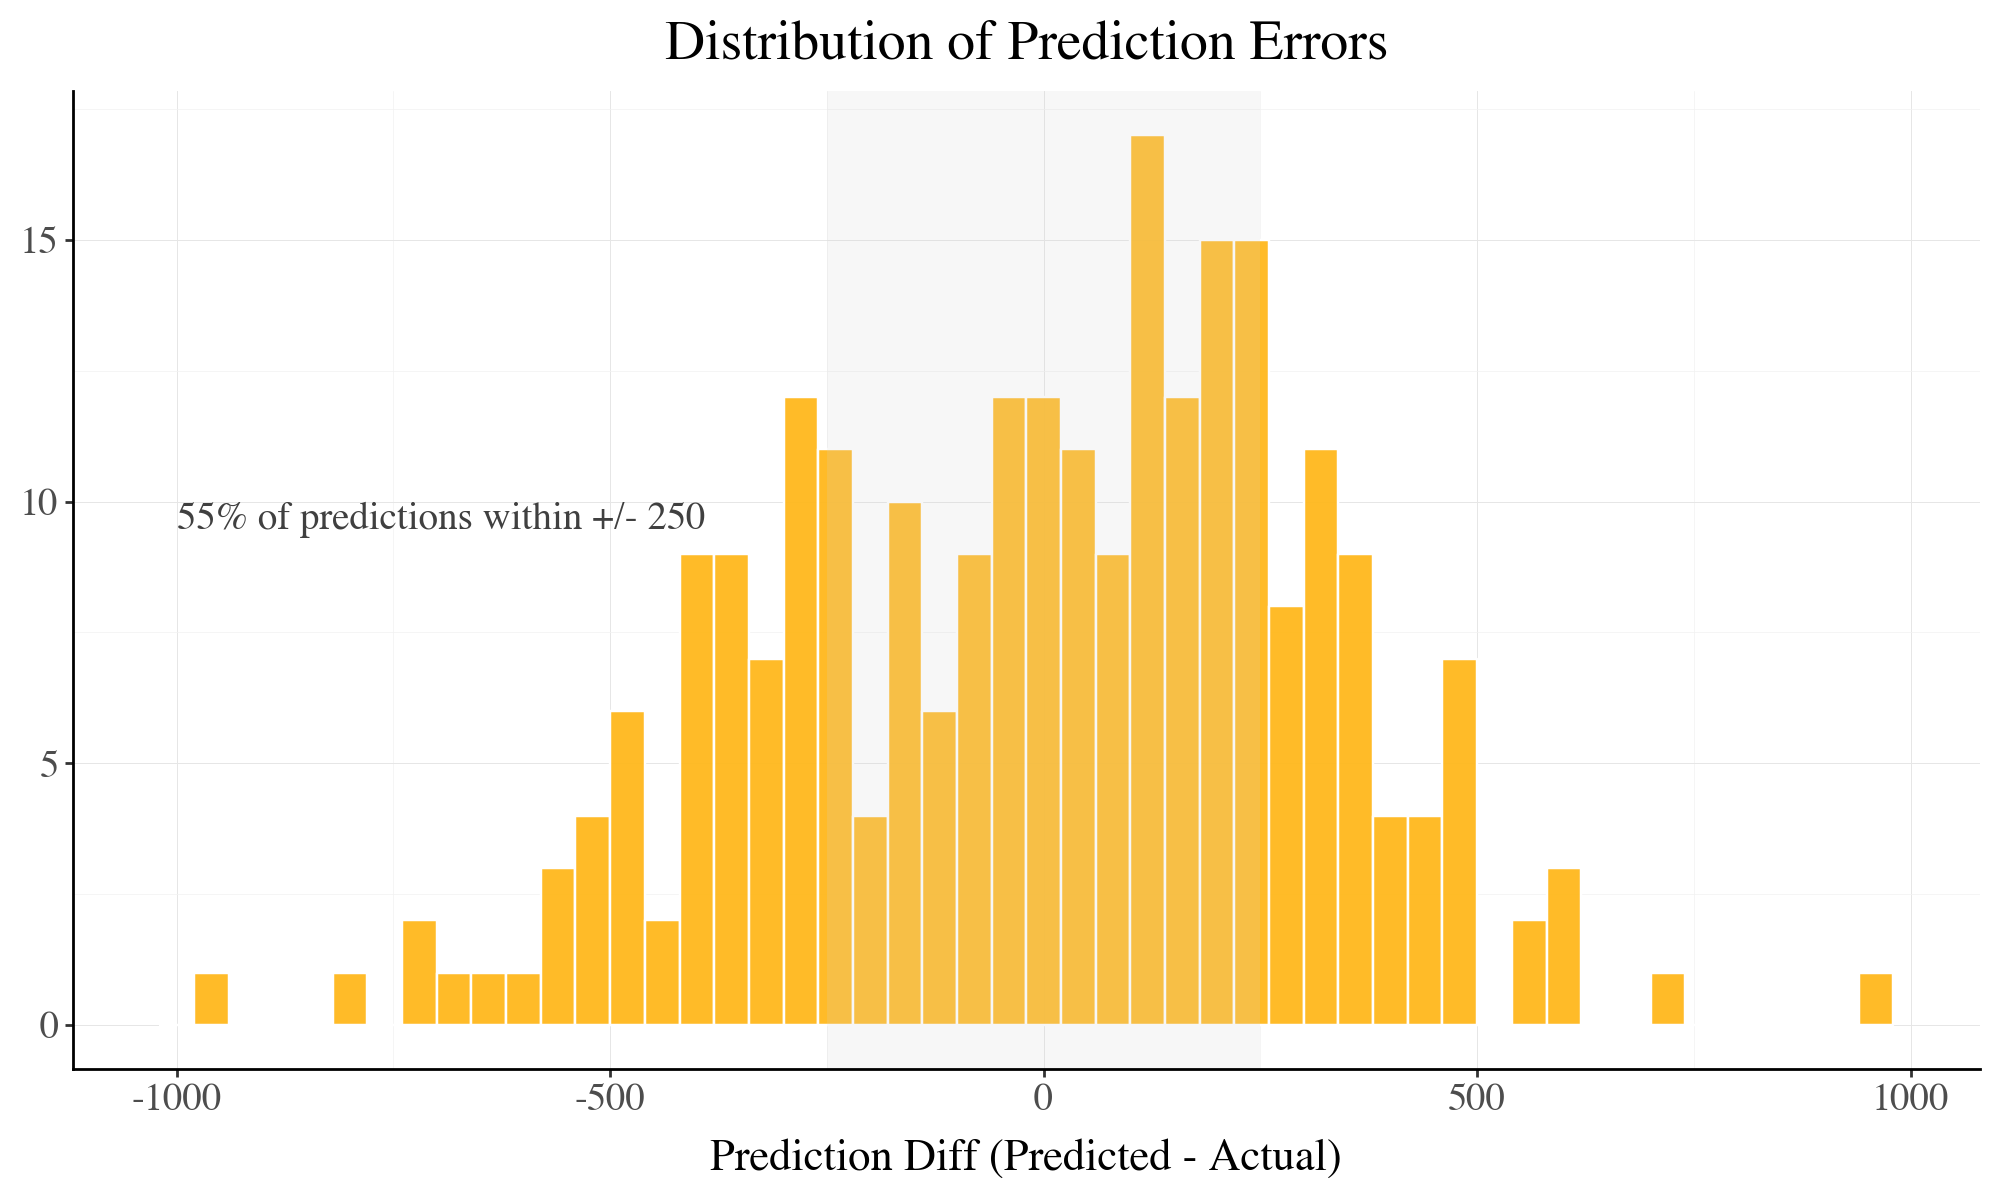

In [129]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=40,
    x_annotate=-1000,    # custom annotation position
    y_annotate=10,      # custom annotation position
)
p3.show()

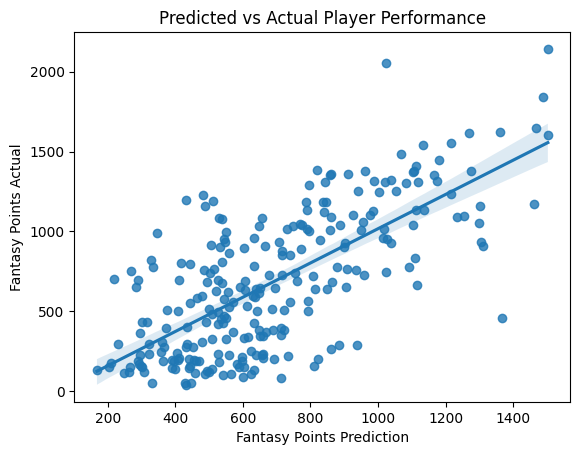

In [42]:
plot_predictions(x_test, y_test, y_pred)

# Creating baseline pitching predictions

In [48]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

Validation Root Mean Squared Error: 186.78865059542807
Validation Mean Absolute Error: 139.29173340335964
Validation R^2 Score: 0.5080843996317356
Test Root Mean Squared Error: 218.76904896557807
Test Mean Absolute Error: 165.60911839906018
Test R^2 Score: 0.31933884130393


# Pitching Predictions

In [ ]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=25,
    random_state=62820,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 25/25 [00:16<00:00,  1.53trial/s, best loss: 169.8702616089619] 
Best Parameters: {'learning_rate': 0.1951439065850292, 'max_depth': 3, 'subsample': 0.8043843257851121, 'colsample_bytree': 0.8091557791524338, 'min_child_weight': 2.3043126956705735, 'reg_lambda': 2.0337589261476863, 'reg_alpha': 0.37635956478128035, 'gamma': 0.006866192499263337}
[Best trial @ val] optimized=rmse | RMSE=169.870 | MAE=132.518 | ASYM=37986.934


In [51]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=62820,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 32
[Val] RMSE: 169.870 | MAE: 132.518 | R^2: 0.593 | ASYM: 37986.934
[Test] RMSE: 217.723 | MAE: 165.438 | R^2: 0.326 | ASYM: 59220.862


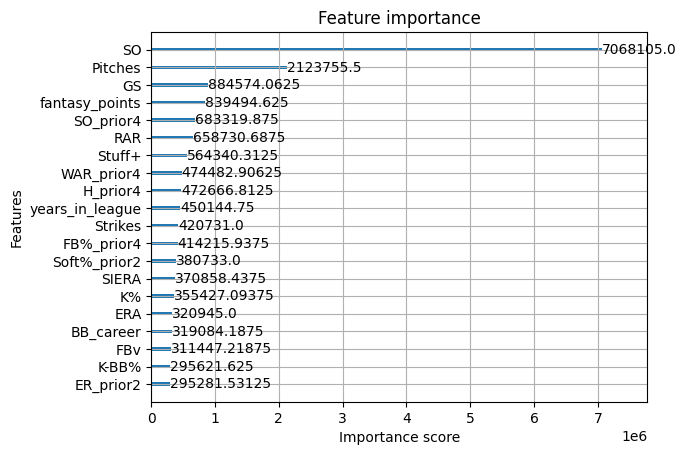

In [53]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=20)
plt.show()

In [ ]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

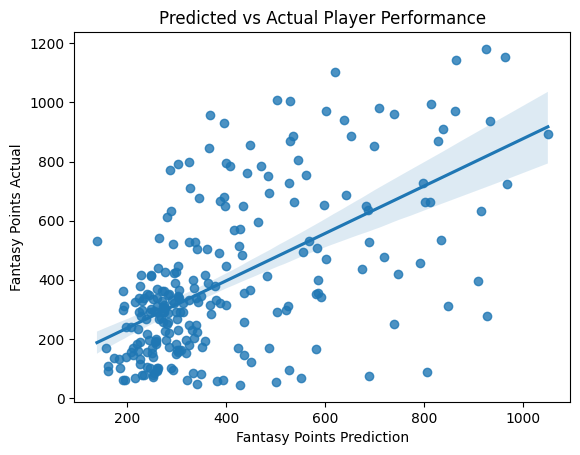

In [52]:
plot_predictions(x_test, y_test, y_pred)

# Predicting Upcoming Season Player Performance

In [185]:
# import pandas as pd
# from pybaseball import batting_stats, pitching_stats, playerid_reverse_lookup
# from helper import calc_fantasy_points_batting, calc_fantasy_points_pitching, add_suffix_to_columns, save_data, load_training_data
# def validate_covid_impact(season, years):
#     """
#     This function checks if the year 2020 occurred during the specified number of years leading up to the given season.
#     """
#     start_year = season - years
#     end_year = season
#     return 2020 in range(start_year, end_year + 1)

# def player_data(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Pulls player data from the pybaseball API and merges it with the provided DataFrame to obtain player rookie seasons.

#     Parameters:
#     df (pd.DataFrame): The DataFrame to which the player data will be added.

#     Returns:
#     pd.DataFrame: The DataFrame with the player data added.
#     """

#     player_ids = df['IDfg'].unique().tolist()
#     player_ids = playerid_reverse_lookup(player_ids, key_type='fangraphs').filter(items = ['key_fangraphs', 'mlb_played_first'])
#     player_ids = player_ids.rename(columns = {'key_fangraphs': 'IDfg', 'mlb_played_first': 'rookie_year'})
#     df = df.merge(player_ids, on = 'IDfg', how = 'left')
    
#     # Add total years in league to the data for each player for context on eligible playing years
#     df['years_in_league'] = df['Season'] - df['rookie_year']
#     return df

# def pull_prediction_data(prediction_year: int, agg_years: int, batting_stat_cols: list, pitching_stat_cols: list) -> tuple:
#     """
#     Pulls and processes batting and pitching data for the specified years.

#     Parameters:
#     end_year (int): The end year for the data pull.
#     agg_years (int): The number of years to aggregate for prior data.
#     batting_stat_cols (list): List of columns to include in the batting data.
#     pitching_stat_cols (list): List of columns to include in the pitching data.

#     Returns:
#     tuple: A tuple containing two DataFrames, one for batting data and one for pitching data.
#     """
#     # Initialize empty DataFrames
#     batting_df = pd.DataFrame()
#     pitching_df = pd.DataFrame()

#     # Creating start and end years for the aggregated data pull of prior player seasons
#     end_year_prior = prediction_year - 1
#     start_year_prior = end_year_prior - agg_years

#     # Pulling batting stats
#     batting_df_current = (
#         batting_stats(start_season = prediction_year, # Selecting a single season for most recent stats
#                         qual = 50,
#                         split_seasons = True)
#                         .filter(items = batting_stat_cols)
#     )
#     calc_fantasy_points_batting(batting_df_current, 'fantasy_points')

#     batting_df_prior = (
#         batting_stats(start_season = start_year_prior, 
#                         end_season = end_year_prior,
#                         qual = 50,
#                         split_seasons = False)
#                         .filter(items = batting_stat_cols)
#     )
#     batting_df_prior = batting_df_prior.drop(columns = ['Name', 'Age']) # Dropping redundant columns for joining
#     calc_fantasy_points_batting(batting_df_prior, 'fantasy_points_prior')
#     batting_df_prior = add_suffix_to_columns(batting_df_prior, '_prior', exclude_columns = ['IDfg', 'fantasy_points_prior'])

#     # Combining batting features into single dataframe and replace NaN values with 0
#     batting_df_current = (batting_df_current.merge(batting_df_prior, on = 'IDfg', how = 'left')
#     )

#     # Pulling pitching stats
#     pitching_df_current = (
#         pitching_stats(start_season = prediction_year, # Selecting a single season for most recent stats
#                         qual = 20,
#                         split_seasons = True)
#                         .filter(items = pitching_stat_cols)
#     )
#     calc_fantasy_points_pitching(pitching_df_current, 'fantasy_points')

#     pitching_df_prior = (
#         pitching_stats(start_season = start_year_prior, 
#                         end_season = end_year_prior,
#                         qual = 20,
#                         split_seasons = False)
#                         .filter(items = pitching_stat_cols)
#     )
#     pitching_df_prior = pitching_df_prior.drop(columns = ['Name', 'Age']) # Dropping redundant columns for joining
#     calc_fantasy_points_pitching(pitching_df_prior, 'fantasy_points_prior')
#     pitching_df_prior = add_suffix_to_columns(pitching_df_prior, '_prior', exclude_columns = ['IDfg', 'fantasy_points_prior'])

#     # Combining pitching features into single dataframe & replace NaN values with 0
#     pitching_df_current = (pitching_df_current.merge(pitching_df_prior, on = 'IDfg', how = 'left')
#     )

#     # Append the results to the main DataFrames
#     batting_df = pd.concat([batting_df, batting_df_current], ignore_index=True)
#     pitching_df = pd.concat([pitching_df, pitching_df_current], ignore_index=True)

#     # Add a column to indicate if the season is during the COVID-19 pandemic
#     batting_df['covid_season'] = batting_df['Season'] == 2020
#     pitching_df['covid_season'] = pitching_df['Season'] == 2020

#     # Add a column to indicate if the prior seasons were during the COVID-19 pandemic
#     batting_df['covid_impact'] = batting_df['Season'].apply(lambda x: validate_covid_impact(x, agg_years))
#     pitching_df['covid_impact'] = pitching_df['Season'].apply(lambda x: validate_covid_impact(x, agg_years))

#     # Add player rookie seasons onto the data, helps with modeling new players vs veterans
#     batting_df = player_data(batting_df)
#     pitching_df = player_data(pitching_df)

#     # Replacing NaN values with 0
#     batting_df.fillna(0, inplace=True)
#     pitching_df.fillna(0, inplace=True)

#     return batting_df, pitching_df

In [186]:
batting_new, pitching_new = pull_prediction_data(prediction_year=PRED_YEAR,
                                            agg_years=AGG_YEARS, 
                                            batting_stat_cols=batting_stat_cols, 
                                            pitching_stat_cols=pitching_stat_cols)

In [187]:
batting_predictions = batting_model.predict(batting_new.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_new.drop(columns=['IDfg', 'Name']))

In [188]:
batting_new['fantasy_points_pred'] = batting_predictions
pitching_new['fantasy_points_pred'] = pitching_predictions

batting_new.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_new.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [189]:
display(batting_new)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,Hard%_prior,FB%_prior,EV_prior,HardHit%_prior,fantasy_points_prior,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred
2,19755,2024,Shohei Ohtani,29,159,636,197,98,38,7,...,0.428,0.357,93.1,0.504,6947.0,False,True,2018.0,6.0,1604.961304
0,15640,2024,Aaron Judge,32,158,559,180,85,36,1,...,0.492,0.393,95.8,0.583,7086.0,False,True,2016.0,8.0,1490.744629
3,20123,2024,Juan Soto,25,157,576,166,90,31,4,...,0.376,0.328,92.0,0.495,8099.0,False,True,2018.0,6.0,1485.821655
1,25764,2024,Bobby Witt Jr.,24,161,636,211,123,45,11,...,0.344,0.449,90.2,0.422,2859.0,False,True,2022.0,2.0,1474.433838
7,13510,2024,Jose Ramirez,31,158,620,173,93,39,2,...,0.350,0.465,89.1,0.377,8348.0,False,True,2013.0,11.0,1462.773438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,10200,2024,Tucker Barnhart,33,31,81,14,11,3,0,...,0.309,0.329,86.4,0.278,2839.0,False,True,2014.0,10.0,27.844866
424,13663,2024,Jack Lopez,31,27,67,17,13,3,0,...,0.000,0.000,0.0,0.000,0.0,False,True,2021.0,3.0,26.492601
510,10950,2024,Adam Duvall,35,104,303,55,34,10,0,...,0.356,0.530,89.1,0.407,3978.0,False,True,2014.0,10.0,19.898624
367,5760,2024,Avisail Garcia,33,18,50,12,9,1,0,...,0.362,0.310,89.6,0.431,3896.0,False,True,2012.0,12.0,-19.838919


In [190]:
display(pitching_new)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,Hard%_prior,Pitching+_prior,Location+_prior,Stuff+_prior,fantasy_points_prior,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred
2,10310,2024,Zack Wheeler,34,32,32,3136,2057,16,5.4,...,0.272,118.0,105.0,113.0,5397.0,False,True,2013.0,11.0,963.850220
10,25436,2024,George Kirby,26,33,33,2969,2032,14,4.2,...,0.322,108.0,111.0,100.0,1620.6,False,True,2022.0,2.0,871.324341
28,16149,2024,Aaron Nola,31,33,33,3193,2092,14,3.2,...,0.320,111.0,107.0,106.0,5856.3,False,True,2015.0,9.0,851.293396
1,22267,2024,Tarik Skubal,27,31,31,2868,1985,18,5.9,...,0.329,106.0,103.0,103.0,2023.3,False,True,2020.0,4.0,841.891296
26,30134,2024,Tanner Bibee,25,31,31,2853,1890,12,3.3,...,0.302,96.0,102.0,95.0,758.0,False,True,2023.0,1.0,826.551453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,25862,2024,Noah Davis,27,9,0,365,234,0,0.0,...,0.381,81.0,90.0,93.0,84.0,False,True,2022.0,2.0,19.496302
565,14361,2024,Ty Blach,33,20,12,1133,756,3,-0.6,...,0.374,84.0,106.0,82.0,874.0,False,True,2016.0,8.0,12.449790
537,16408,2024,Victor Gonzalez,28,27,0,386,227,2,-0.4,...,0.242,100.0,91.0,110.0,474.3,False,True,2020.0,4.0,8.204277
576,12056,2024,Scott McGough,34,26,2,578,359,1,-0.7,...,0.393,90.0,95.0,94.0,367.3,False,True,2015.0,9.0,-0.322252


In [191]:
batting_new = split_name(batting_new, 'Name')
pitching_new = split_name(pitching_new, 'Name')

In [192]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_new, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
481,13301.0,2024.0,Max Muncy,33.0,73.0,237.0,55.0,23.0,17.0,0.0,...,False,True,2015.0,9.0,653.819946,max,muncy,LAD,3B,1056.0
482,13301.0,2024.0,Max Muncy,33.0,73.0,237.0,55.0,23.0,17.0,0.0,...,False,True,2015.0,9.0,653.819946,max,muncy,ATH,"2B,SS",113.0


In [193]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 150
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 150))]

display(batting_final)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,5297.0,2024.0,Aaron Hicks,34.0,18.0,57.0,8.0,7.0,0.0,0.0,...,False,True,2013.0,11.0,-20.158295,aaron,hicks,NaN,DH,28.0
1,15640.0,2024.0,Aaron Judge,32.0,158.0,559.0,180.0,85.0,36.0,1.0,...,False,True,2016.0,8.0,1490.744629,aaron,judge,NYY,"LF,CF,RF,DH",1712.0
2,25524.0,2024.0,Aaron Schunk,26.0,39.0,94.0,22.0,17.0,3.0,0.0,...,False,True,0.0,0.0,59.198505,aaron,schunk,COL,"2B,3B",129.0
3,19844.0,2024.0,Abraham Toro,27.0,94.0,337.0,81.0,57.0,17.0,1.0,...,False,True,2019.0,5.0,467.728363,abraham,toro,BOS,"2B,3B",126.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,adael,amador,COL,2B,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,31347.0,2024.0,Zach Neto,23.0,155.0,542.0,135.0,77.0,34.0,1.0,...,False,True,2023.0,1.0,1073.121948,zach,neto,LAA,SS,1040.0
712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,zach,remillard,NaN,DH,59.0
713,31562.0,2024.0,Zachary Dezenzo,24.0,19.0,62.0,15.0,11.0,2.0,0.0,...,False,True,0.0,0.0,140.605377,zachary,dezenzo,NaN,NaN,NaN
714,29766.0,2024.0,Zack Gelof,24.0,138.0,497.0,105.0,66.0,20.0,2.0,...,False,True,2023.0,1.0,936.949280,zack,gelof,ATH,2B,1101.0


In [194]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_new, pitching_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
601,6984.0,2024.0,Luis Garcia,37.0,60.0,0.0,898.0,593.0,5.0,0.3,...,False,True,2013.0,11.0,168.434784,luis,garcia,HOU,SP,507.0
602,6984.0,2024.0,Luis Garcia,37.0,60.0,0.0,898.0,593.0,5.0,0.3,...,False,True,2013.0,11.0,168.434784,luis,garcia,LAD,RP,182.8


In [195]:
# Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,18655.0,2024.0,A.J. Minter,30.0,39.0,0.0,522.0,354.0,5.0,-0.1,...,False,True,2017.0,7.0,193.704636,a.j.,minter,NYM,RP,314.0
1,19343.0,2024.0,A.J. Puk,29.0,62.0,4.0,1173.0,781.0,4.0,1.7,...,False,True,2019.0,5.0,339.528198,a.j.,puk,ARI,"SP,RP",372.5
2,23550.0,2024.0,Aaron Ashby,26.0,14.0,2.0,484.0,317.0,1.0,0.6,...,False,True,2021.0,3.0,261.707794,aaron,ashby,MIL,RP,455.5
3,12272.0,2024.0,Aaron Brooks,34.0,5.0,4.0,403.0,261.0,0.0,-0.1,...,False,True,2014.0,10.0,29.968746,aaron,brooks,NaN,NaN,NaN
4,16258.0,2024.0,Aaron Bummer,30.0,56.0,0.0,975.0,622.0,4.0,1.1,...,False,True,2017.0,7.0,310.034424,aaron,bummer,ATL,RP,357.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,20349.0,2024.0,Zack Kelly,29.0,49.0,3.0,958.0,610.0,6.0,-0.3,...,False,True,2022.0,2.0,210.070618,zack,kelly,BOS,"SP,RP",165.4
951,15823.0,2024.0,Zack Littell,28.0,29.0,29.0,2488.0,1680.0,8.0,2.3,...,False,True,2018.0,6.0,449.139496,zack,littell,TB,SP,596.0
952,25918.0,2024.0,Zack Thompson,26.0,5.0,2.0,317.0,205.0,0.0,-0.3,...,False,True,2022.0,2.0,127.754280,zack,thompson,STL,"SP,RP",239.4
953,10310.0,2024.0,Zack Wheeler,34.0,32.0,32.0,3136.0,2057.0,16.0,5.4,...,False,True,2013.0,11.0,963.850220,zack,wheeler,PHI,SP,1075.3


In [196]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [197]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [198]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [199]:
# def get_value_before_comma(value):
#     if ',' in value:
#         return value.split(',')[0]
#     return value

# # Apply the function to the column
# batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

In [200]:
# Reset the chained assignment option to its default value
pd.options.mode.chained_assignment = 'warn'

In [201]:
# Display the DataFrame to verify the changes
display(batting_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,5297.0,Aaron Hicks,34.0,NaN,DH,-20.158295,28.0
1,15640.0,Aaron Judge,32.0,NYY,OF,1490.744629,1712.0
2,25524.0,Aaron Schunk,26.0,COL,2B,59.198505,129.0
3,19844.0,Abraham Toro,27.0,BOS,2B,467.728363,126.0
4,NaN,Adael Amador,NaN,COL,2B,NaN,96.0
...,...,...,...,...,...,...,...
711,31347.0,Zach Neto,23.0,LAA,SS,1073.121948,1040.0
712,NaN,Zach Remillard,NaN,NaN,DH,NaN,59.0
713,31562.0,Zachary Dezenzo,24.0,NaN,DH,140.605377,NaN
714,29766.0,Zack Gelof,24.0,ATH,2B,936.949280,1101.0


In [202]:
# Display the DataFrame to verify the changes
display(pitching_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,18655.0,A.J. Minter,30.0,NYM,RP,193.704636,314.0
1,19343.0,A.J. Puk,29.0,ARI,SP,339.528198,372.5
2,23550.0,Aaron Ashby,26.0,MIL,RP,261.707794,455.5
3,12272.0,Aaron Brooks,34.0,NaN,SP,29.968746,NaN
4,16258.0,Aaron Bummer,30.0,ATL,RP,310.034424,357.2
...,...,...,...,...,...,...,...
950,20349.0,Zack Kelly,29.0,BOS,SP,210.070618,165.4
951,15823.0,Zack Littell,28.0,TB,SP,449.139496,596.0
952,25918.0,Zack Thompson,26.0,STL,SP,127.754280,239.4
953,10310.0,Zack Wheeler,34.0,PHI,SP,963.850220,1075.3


# Finalizing Predictions & Creating Relative Positional Value Scores

In [203]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])


pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [204]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [205]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

C:\Users\JB\AppData\Local\Temp\ipykernel_15880\2805261300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
C:\Users\JB\AppData\Local\Temp\ipykernel_15880\2805261300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)
C:\Users\JB\AppData\Local\Temp\ip

In [206]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [207]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [208]:
display(batting_final_if)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank
8,26288.0,Adley Rutschman,26.0,BAL,C,1033.697021,1143.0,1066.487891,41.0
15,21618.0,Alec Bohm,27.0,PHI,1B,1202.883789,1142.0,1184.618616,23.0
16,27615.0,Alec Burleson,25.0,STL,1B,948.343201,959.0,951.540210,74.0
18,22581.0,Alejandro Kirk,25.0,TOR,C,838.857849,735.0,807.700500,100.0
20,17678.0,Alex Bregman,30.0,BOS,3B,1190.434448,1251.0,1208.604077,19.0
...,...,...,...,...,...,...,...,...,...
697,22266.0,Xavier Edwards,24.0,MIA,SS,701.833435,1084.0,816.483386,96.0
698,23003.0,Yainer Diaz,25.0,HOU,C,1049.945679,1036.0,1045.761975,49.0
700,16578.0,Yandy Diaz,32.0,TB,1B,1085.808472,1192.0,1117.665918,33.0
711,31347.0,Zach Neto,23.0,LAA,SS,1073.121948,1040.0,1063.185364,42.0


In [209]:
display(batting_final_of)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank
1,15640.0,Aaron Judge,32.0,NYY,OF,1490.744629,1712.0,1557.121240,1.0
9,19287.0,Adolis Garcia,31.0,TEX,OF,789.973267,1174.0,905.181262,47.0
32,17901.0,Andrew Benintendi,29.0,CWS,OF,755.862732,969.0,819.803882,56.0
42,14551.0,Anthony Santander,29.0,TOR,OF,955.496948,1298.0,1058.247839,28.0
75,20202.0,Brandon Marsh,26.0,PHI,OF,865.148560,973.0,897.504004,48.0
...,...,...,...,...,...,...,...,...,...
665,15711.0,Tyler O'Neill,29.0,BAL,OF,973.372437,974.0,973.560718,40.0
673,18363.0,Victor Robles,27.0,SEA,OF,676.155151,960.0,761.308594,61.0
694,23772.0,Wilyer Abreu,25.0,BOS,OF,1081.045532,931.0,1036.031873,30.0
695,33333.0,Wyatt Langford,22.0,TEX,OF,1101.301392,1268.0,1151.310950,21.0


In [210]:
display(pitching_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank
5,19479.0,Aaron Civale,29.0,MIL,SP,594.769165,701.1,626.668416,67.0
6,16149.0,Aaron Nola,31.0,PHI,SP,851.293396,941.4,878.325377,6.0
21,27451.0,Alec Marsh,26.0,KC,SP,515.468201,493.8,508.967740,105.0
38,26108.0,Andre Pallante,25.0,STL,SP,637.171448,600.4,626.140013,68.0
44,15423.0,Andrew Heaney,33.0,PIT,SP,484.079010,635.2,529.415307,97.0
...,...,...,...,...,...,...,...,...,...
942,20633.0,Yusei Kikuchi,33.0,LAA,SP,809.148987,900.5,836.554291,12.0
943,19291.0,Zac Gallen,28.0,ARI,SP,606.335999,882.0,689.035199,55.0
946,13774.0,Zach Eflin,30.0,BAL,SP,651.311829,782.5,690.668280,54.0
951,15823.0,Zack Littell,28.0,TB,SP,449.139496,596.0,493.197647,109.0


In [211]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [212]:
# Adjusting positional group for Shoehei Ohtani to be OF within the batting_final dataframe (that is his designation on Underdog)
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [213]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [214]:
# Calculating relative positional values
combined_df = calculate_relative_value(combined_df, position_col='position_group', projection_col='final_projection')
# Creating positional ranks based on player relative values
combined_df['position_rank'] = combined_df.groupby('Position')['relative_value'].rank(ascending=False, method='dense')

d:\JB\development\baseball_modeling\clean_and_cluster.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["relative_value"].fillna(0, inplace=True)


In [215]:
display(combined_df)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank,position_group,relative_value,final_ranking,position_rank
0,26288.0,Adley Rutschman,26.0,BAL,C,1033.697021,1143.0,1066.487891,41.0,IF,61.173189,127.0,2.0
1,21618.0,Alec Bohm,27.0,PHI,1B,1202.883789,1142.0,1184.618616,23.0,IF,878.095519,57.0,7.0
2,27615.0,Alec Burleson,25.0,STL,1B,948.343201,959.0,951.540210,74.0,IF,-578.632605,218.0,20.0
3,22581.0,Alejandro Kirk,25.0,TOR,C,838.857849,735.0,807.700500,100.0,IF,-1163.754818,287.0,12.0
4,17678.0,Alex Bregman,30.0,BOS,3B,1190.434448,1251.0,1208.604077,19.0,IF,1063.698741,45.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,20633.0,Yusei Kikuchi,33.0,LAA,SP,809.148987,900.5,836.554291,12.0,P,1140.623266,41.0,12.0
284,19291.0,Zac Gallen,28.0,ARI,SP,606.335999,882.0,689.035199,55.0,P,93.557759,123.0,55.0
285,13774.0,Zach Eflin,30.0,BAL,SP,651.311829,782.5,690.668280,54.0,P,103.166358,121.0,54.0
286,15823.0,Zack Littell,28.0,TB,SP,449.139496,596.0,493.197647,109.0,P,-736.855345,243.0,109.0


# Create Player Value Segments

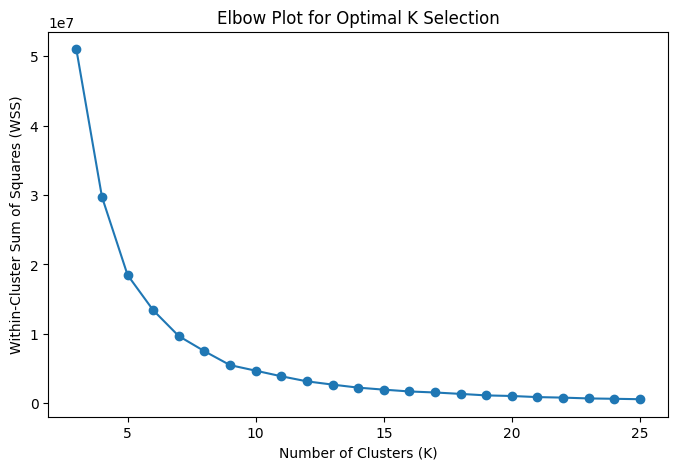

In [216]:
# Evaluating clustering performance on varying K values

determine_optimal_k(combined_df, max_k = 25)

In [217]:
# Setting a K of 18 and placing players into relative value tiers
final_df = segment_players(combined_df, k = 18)

In [218]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

In [219]:
display(final_df)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank,position_group,relative_value,final_ranking,position_rank,player_value_tier
83,19755.0,Shohei Ohtani,29.0,LAD,OF,1604.961304,1737.0,1644.572900,1.0,OF,4556.627027,1.0,1.0,1
10,25764.0,Bobby Witt Jr.,24.0,KC,SS,1474.433838,1604.0,1513.303638,2.0,IF,4001.305370,2.0,1.0,2
101,15640.0,Aaron Judge,32.0,NYY,OF,1490.744629,1712.0,1557.121240,1.0,OF,3708.297913,3.0,2.0,3
48,13510.0,Jose Ramirez,31.0,CLE,3B,1462.773438,1514.0,1478.141406,3.0,IF,3607.438722,4.0,1.0,3
138,20123.0,Juan Soto,25.0,NYM,OF,1485.821655,1623.0,1526.975195,2.0,OF,3431.641936,5.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,24262.0,Ceddanne Rafaela,23.0,BOS,2B,816.478027,816.0,816.334607,97.0,IF,-1135.390586,284.0,23.0,18
80,16442.0,Ryan O'Hearn,30.0,BAL,1B,827.286743,778.0,812.500708,98.0,IF,-1148.092016,285.0,27.0,18
86,22514.0,Triston Casas,24.0,BOS,1B,644.122375,1192.0,808.485651,99.0,IF,-1161.211168,286.0,28.0,18
3,22581.0,Alejandro Kirk,25.0,TOR,C,838.857849,735.0,807.700500,100.0,IF,-1163.754818,287.0,12.0,18


In [220]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y')}.csv', index=False)